# Shot Charts dos Jogadores da NBA 2022-23

## Importing libraries

In [29]:
# For data wrangling
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data acquisition
from nba_api.stats.endpoints import playercareerstats, shotchartdetail
from nba_api.stats.static import players
from scipy.stats import norm, gaussian_kde, percentileofscore


# For plotting the court
from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Setting the workspace
sns.set_style('white')
sns.set_color_codes()
pd.options.display.max_columns = None

## Drawing the court

In [2]:
def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False):
    """Returns an axes with a basketball court drawn onto to it.
    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example the center of the
    hoop is located at the (0,0) coordinate.  Twenty-two feet from the left of
    the center of the hoop in is represented by the (-220,0) coordinates.
    So one foot equals +/-10 units on the x and y-axis.
    Parameters
    ----------
    ax : Axes, optional
        The Axes object to plot the court onto.
    color : matplotlib color, optional
        The color of the court lines.
    lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If `True` it draws the out of bound lines in same style as the rest of
        the court.
    Returns
    -------
    ax : Axes
        The Axes object with the court on it.
    """
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # Draw shotzone Lines
    # Based on Advanced Zone Mode
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='black', fill=False)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='black', fill=False)
        corner_three_a_x =  Rectangle((-250, 92.5), 30, 0, linewidth=lw, color=color)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color=color)
        
        # 60 degrees
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color=color)
        # 120 degrees
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color=color)
        
        # Assume x distance is also 40 for the endpoint
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color=color)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color=color)
        
        # Assume y distance is also 92.5 for the endpoint
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color=color)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color=color)
        
        
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x,
                          inner_line_1, inner_line_2, inner_line_3, inner_line_4, inner_line_5, inner_line_6]
    else:
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

## Getting the data from the nba_api

In [3]:
def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: name of the player with Capital
    season_id: ex. 2012-13
    """
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # career df
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

In [22]:
player_shotchart_df, league_avg = get_player_shotchartdetail('Jayson Tatum', '2022-23')

In [23]:
player_shotchart_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022200001,15,1628369,Jayson Tatum,1610612738,Boston Celtics,1,10,46,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,49,1,1,20221018,BOS,PHI
1,Shot Chart Detail,0022200001,39,1628369,Jayson Tatum,1610612738,Boston Celtics,1,9,42,Made Shot,Running Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,-4,1,1,20221018,BOS,PHI
2,Shot Chart Detail,0022200001,71,1628369,Jayson Tatum,1610612738,Boston Celtics,1,7,55,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-140,218,1,0,20221018,BOS,PHI
3,Shot Chart Detail,0022200001,208,1628369,Jayson Tatum,1610612738,Boston Celtics,2,10,38,Missed Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-144,161,1,0,20221018,BOS,PHI
4,Shot Chart Detail,0022200001,223,1628369,Jayson Tatum,1610612738,Boston Celtics,2,9,57,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,10,-27,106,1,1,20221018,BOS,PHI


## Shot chart

In [24]:
def shot_chart(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="black",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    # separate color by make or miss    
    x_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_X']
    y_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_Y']

    x_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_X']
    y_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_Y']

    # plot missed shots
    ax.scatter(x_missed, y_missed, c='r', s=90, **kwargs, alpha=.8)
    # plot made shots
    ax.scatter(x_made, y_made, facecolors='none', c='g', s=90, **kwargs, alpha=.8)
        
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

In [25]:
plt.rcParams['figure.figsize'] = (12, 11)

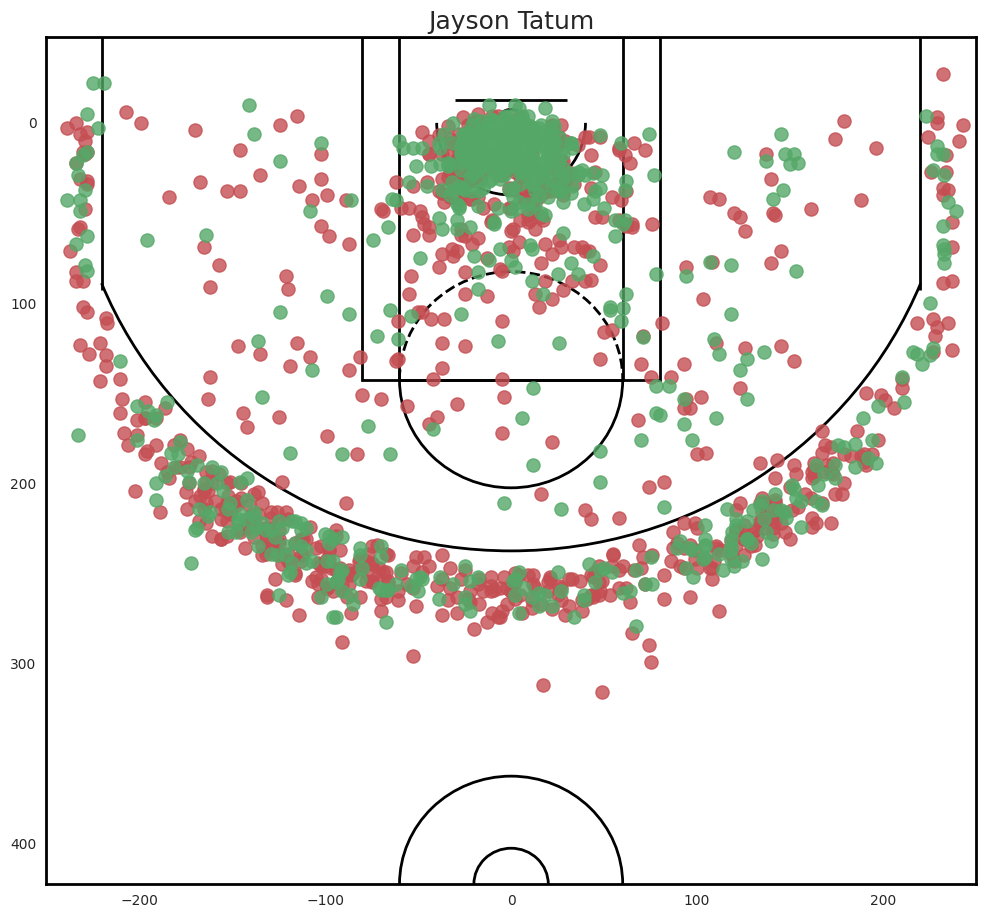

In [26]:
shot_chart(player_shotchart_df, 
           title="{[0]}".format(player_shotchart_df['PLAYER_NAME']), 
           flip_court=False,
           court_lw=2)
plt.show()

In [36]:
player_shotchart_df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022200001,15,1628369,Jayson Tatum,1610612738,Boston Celtics,1,10,46,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,49,1,1,20221018,BOS,PHI
1,Shot Chart Detail,0022200001,39,1628369,Jayson Tatum,1610612738,Boston Celtics,1,9,42,Made Shot,Running Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,-4,1,1,20221018,BOS,PHI
2,Shot Chart Detail,0022200001,71,1628369,Jayson Tatum,1610612738,Boston Celtics,1,7,55,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-140,218,1,0,20221018,BOS,PHI
3,Shot Chart Detail,0022200001,208,1628369,Jayson Tatum,1610612738,Boston Celtics,2,10,38,Missed Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,21,-144,161,1,0,20221018,BOS,PHI
4,Shot Chart Detail,0022200001,223,1628369,Jayson Tatum,1610612738,Boston Celtics,2,9,57,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,10,-27,106,1,1,20221018,BOS,PHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,Shot Chart Detail,0022201206,111,1628369,Jayson Tatum,1610612738,Boston Celtics,1,3,7,Made Shot,Driving Layup Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,48,7,1,1,20230407,BOS,TOR
1555,Shot Chart Detail,0022201206,136,1628369,Jayson Tatum,1610612738,Boston Celtics,1,1,15,Missed Shot,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-153,221,1,0,20230407,BOS,TOR
1556,Shot Chart Detail,0022201206,152,1628369,Jayson Tatum,1610612738,Boston Celtics,1,0,27,Made Shot,Running Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,6,1,1,20230407,BOS,TOR
1557,Shot Chart Detail,0022201206,269,1628369,Jayson Tatum,1610612738,Boston Celtics,2,3,34,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-15,8,1,1,20230407,BOS,TOR


In [46]:
df_aux = player_shotchart_df[['PLAYER_ID', 'EVENT_TYPE']].groupby('EVENT_TYPE').count().T.reset_index()

In [47]:
df_aux['Made Shot']/(df_aux['Made Shot'] + df_aux['Missed Shot'])

0    0.466325
dtype: float64